# NLP Problems Step by Step
https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e




In [1]:
import nltk
import pandas as pd
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Data Import and Description

Positive = 5
Negative = 1

## Format the Data

In [2]:
os.chdir('C:\\Users\\Harrison\\Desktop\\APT')
df = pd.read_csv('train.csv', encoding='latin-1')


#dropping NaN and middle response to setup a binary analysis
df = df[df['sentiment']!="3"]
df = df[df['sentiment']!='not_relevant']
df = df.reset_index()

#dropping the extra
df = df.drop(['index', '_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'date','id','query', 'sentiment_gold'], axis =1)

def encoder(x):
    #A simple class encoder to get to 1s and 0s
    if x=='5':
        return 1
    else:
        return 0

#Apply encoder to sentiment column
df['sentiment'] = df['sentiment'].apply(encoder)

print(df.head())
print('\n\nSentiment Values \n', df.sentiment.value_counts())

   sentiment  sentiment:confidence  \
0          1                0.8468   
1          1                0.6736   
2          0                1.0000   
3          1                1.0000   
4          0                1.0000   

                                                text  
0  Top 3 all @Apple #tablets. Damn right! http://...  
1  CNBCTV: #Apple's margins better than expected?...  
2  WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...  
3  RT @peterpham: Bought my @AugustSmartLock at t...  
4  @apple Contact sync between Yosemite and iOS8 ...  


Sentiment Values 
 0    1219
1     423
Name: sentiment, dtype: int64


In [3]:
print(df.sentiment.describe())

count    1642.000000
mean        0.257613
std         0.437453
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: sentiment, dtype: float64


## Clean the Data

In [6]:
from sklearn.model_selection import train_test_split

def standardize_text(df, text_field):
    #removes special strings and non text
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'text')
df.to_csv('clean_apple.csv')
df.head()

,sentiment,sentiment:confidence,text
0,1,0.8468,top 3 all tablets damn right!
1,1,0.6736,cnbctv apple's margins better than expected?...
2,0,1.0000,wtf my battery was 31 one second ago and now ...
3,1,1.0000,rt bought my at the store pretty good logo...
4,0,1.0000,contact sync between yosemite and ios8 is ser...


##  Data Tokenization

In [7]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()

,sentiment,sentiment:confidence,text,tokens
0,1,0.8468,top 3 all tablets damn right!,"[top, 3, all, tablets, damn, right]"
1,1,0.6736,cnbctv apple's margins better than expected?...,"[cnbctv, apple, s, margins, better, than, expe..."
2,0,1.0000,wtf my battery was 31 one second ago and now ...,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,1,1.0000,rt bought my at the store pretty good logo...,"[rt, bought, my, at, the, store, pretty, good,..."
4,0,1.0000,contact sync between yosemite and ios8 is ser...,"[contact, sync, between, yosemite, and, ios8, ..."


In [8]:
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set([word for tokens in df['tokens'] for word in tokens])))

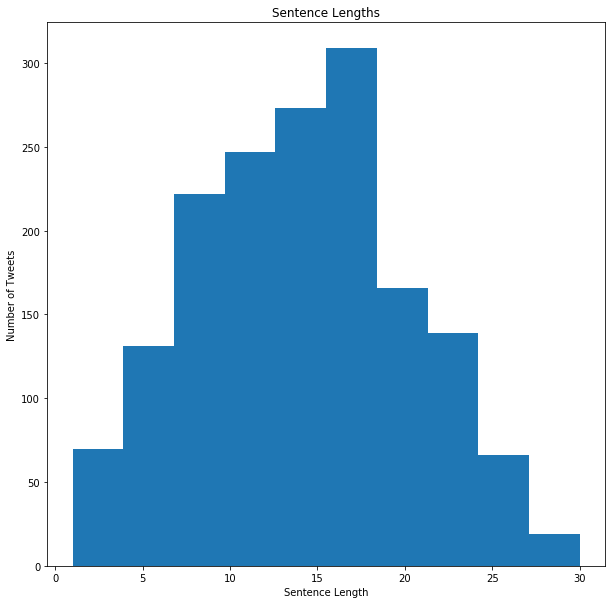

In [16]:
plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [14]:
print('Words in vocab: ', len(vocab))

Words in vocab:  3701


# Bag of Words

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)


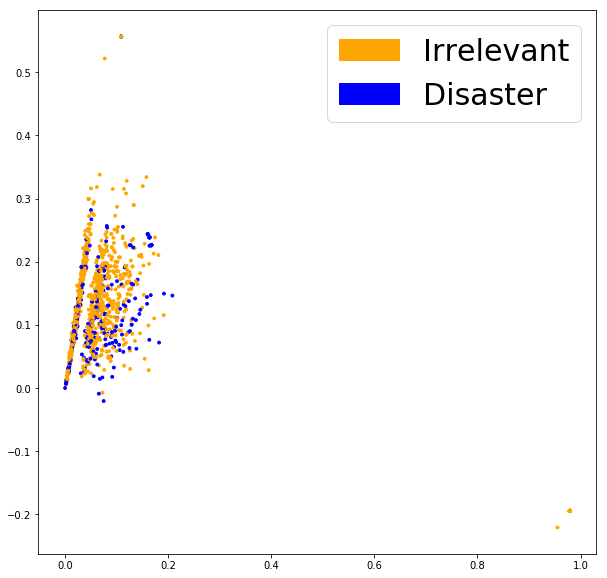

In [22]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')
        green_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
        
fig = plt.figure(figsize =(10,10))
plot_lsa(X_train_tfidf, y_train)
plt.show()

In [25]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(class_weight = 'balanced', n_jobs = -1)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

## Evaluation

Guessing the most comon class would give 74.2% accuract, so our classifier is doing well. Note a fairly even precision and recall for both classes.

In [33]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy: ', accuracy_score(y_test, y_pred))

print('\n\nClassification Report: \n\n' , classification_report(y_test,  y_pred))

Accuracy:  0.8328267477203647


Classification Report: 

              precision    recall  f1-score   support

          0       0.89      0.89      0.89       244
          1       0.67      0.68      0.68        85

avg / total       0.83      0.83      0.83       329



## Inspection


In [36]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

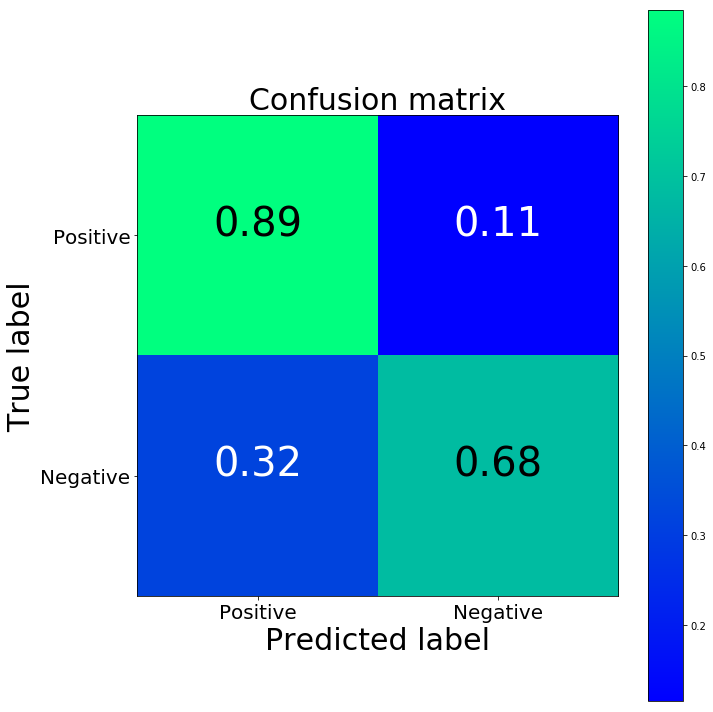

[[216  28]
 [ 27  58]]


In [40]:
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Negative'], normalize = True, title='Confusion matrix')
plt.show()
print(cm)

In [42]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, clf, 10)

In [54]:
importance

{0: {'tops': [(2.087832614332908, 'new'),
   (2.1328617645861736, 'thank'),
   (2.177298829541251, 'for'),
   (2.2927006999997395, 'aapl'),
   (2.5448132613577243, 'best'),
   (2.5627023086206417, 'good'),
   (3.1143771788837693, 'amazing'),
   (3.2149327653572874, 'awesome'),
   (3.4117603676298693, 'great'),
   (4.053034672239295, 'love')],
  'bottom': [(-1.8060040279046792, 'no'),
   (-1.8230061413588654, 'hate'),
   (-1.8873315750358526, 'when'),
   (-1.9422958019376972, 'not'),
   (-1.9717627652129475, 'your'),
   (-2.0249906229289634, 'fix'),
   (-2.247361352975242, 'what'),
   (-2.643425105088454, 'shit'),
   (-3.061423342326696, 'why'),
   (-3.907852254992515, 'fuck')]}}

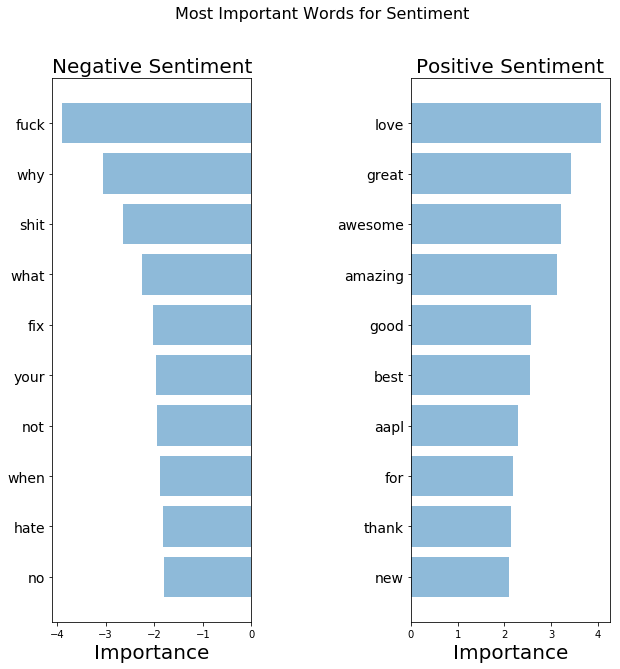

In [55]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Sentiment', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Sentiment', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words for Sentiment")